# Kaggle competiotion. Catch me if You can (Alice) 

## Задача:
Идентифицировать взломщика по его поведению в сети Интернет. В двух словах, взломщик будет себя вести не так, как владелец ящика.


Задача, разработать алгоритм который будет анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определять, Элис это или взломщик (кто-то другой).

## Данные:
__train_sessions.csv:__ обучающая выборка 

    site_i – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем site_dic.pkl)
    time_j – время посещения сайтов site_j
    target – факт того, что сессия принадлежит Элис (то есть что именно Элис ходила по всем этим сайтам)

__test_sessions.csv__ - тестовые данные по которым необходимо определить, принадлежат ли они Элис.

__train.zip__ - исходные данные о посещенных пользователями веб-страницах, по которым можно сформировать свою обучающую выборку.

__site_dic.pkl__ - расшифровка посещенных сайтов

## 1. Load and prepare Data

In [178]:
import os
import re 
import pickle
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
PATH='/Users/nikita/Desktop/git/data/catch_me/'
SEED = 42
AUTHOR = 'Nikita_Kozhevatov'

In [71]:
def prepare_parced_data(path_to_train, path_to_test, path_to_dict):
    
    # let`s load data. columns time1...time10 has str type and need to be parsed.
    times = ['time%s' %i for i in np.arange(1,11)]
    train_data = pd.read_csv(path_to_train, parse_dates=times, index_col='session_id')
    test_data =  pd.read_csv(path_to_test, parse_dates=times, index_col='session_id')
    
    # as further time_split_crossvalidation will be used it`s better to sort sessions by session start time
    train_data = train_data.sort_values(by = 'time1')
    
    #dictionary with encoded sites
    with open(path_to_dict, 'rb') as f: 
        site_dict = pickle.load(f)
    
    # dictionary stores data in format 'site_name':'site_id'. It`s more convenient to swap key and value
    site_dict = {i:j for (j,i) in site_dict.items()}
    site_dict[0] = 'empty'
    
    # now for all site columns (site1....site10) we can replace site_id with site_name
    sites = ['site%s' %i for i in range(1,11)]
    train_data[sites] = train_data[sites].fillna(0).astype(int).applymap(lambda x: site_dict[x])
    test_data[sites] = test_data[sites].fillna(0).astype(int).applymap(lambda x: site_dict[x])
    
    return train_data, test_data, sites, times

In [4]:
train_data, test_data, sites, times = (
    prepare_parced_data(
        path_to_train= os.path.join(PATH,'train_sessions.csv'),
        path_to_test = os.path.join(PATH,'test_sessions.csv'),
        path_to_dict = os.path.join(PATH, 'site_dic.pkl')
    )
)

## Logit Model & Support Functions

In [70]:
# LOGISTIC REGRESSION HYPERPARAMS
logit_params = {'solver': 'liblinear', 'random_state': 42}

In [24]:
def cross_val_on_logit (X_train, y, logit_params):
    logit = LogisticRegression(**logit_params)
    cv = cross_val_score(logit, X_train, y, cv=5, scoring = 'roc_auc', n_jobs=-1)
    print(cv, 'среднее значение на кросс-валидации = ', cv.mean())

In [34]:
def logit_prediction (X_train, X_test, y, logit_params):
    logit = LogisticRegression(**logit_params)
    logit.fit(X_train,y)
    y_pred = logit.predict_proba(X_test)
    return y_pred

In [65]:
def write_to_submission_file(predicted_labels, out_file, target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(
        predicted_labels, 
        index = np.arange(1, predicted_labels.shape[0] + 1), 
        columns=[target])    
    predicted_df.to_csv(out_file, index_label = index_label)

## 2. Create Baseline Feature (TfidVectorized Site Sessions)

In [26]:
# В соревновании Kaggle в основном участники отталкиваются от информации о посещенных сайтах
# Параметры векторизации посещенных сайтов
vectorizer_params = {
    'tokenizer': lambda session: session.split(),
    'ngram_range': (1,1)
#    'max_features': 50000
}

In [73]:
def visited_sites_feature (train_data, test_data, sites, vectorizer_params):
    
    # Vectorizer recieve Collection of documents so we has to transform sessions into list with users sessions
    train_sessions = train_data[sites].apply(lambda row: ' '.join(i for i in row), axis=1).to_list()
    test_sessions = test_data[sites].apply(lambda row: ' '.join(i for i in row), axis=1).to_list()
    
    tfid_vectorizer = TfidfVectorizer(**vectorizer_params)
    
    # Create sparse_matrix
    X_train = tfid_vectorizer.fit_transform(train_sessions)
    X_test = tfid_vectorizer.transform(test_sessions)
    
    return X_train, X_test

In [28]:
X_train, X_test = visited_sites_feature(train_data, test_data, sites, vectorizer_params)

In [30]:
y = train_data['target']

In [31]:
cross_val_on_logit (X_train, y, logit_params)

[0.91359045 0.78698162 0.86264159 0.8922654  0.92027923] среднее значение на кросс-валидации =  0.8751516574547319


__SUBMISSION (LogisticRegression + Vectorized site sessions):__
                        CV_score = 0.875, Kaggle_public = NOT PUBLISHED

____

## Add Feature (Session Start time)

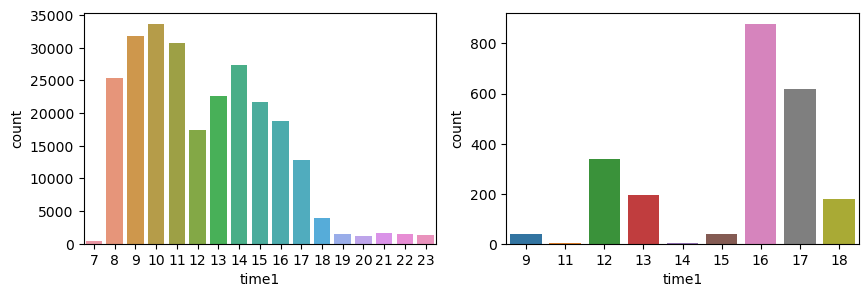

In [75]:
# LET`S LOOK AT SESSION TIME DISTRIBUTION AMONG ALL USERS AND ALICE ONLY.
session_start_hour = train_data['time1'].apply(lambda x: x.hour)
alice_session_start_hour = train_data[train_data['target'] == 1]['time1'].apply(lambda x: x.hour)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
sns.countplot(x = session_start_hour)

plt.subplot(1,2,2)
sns.countplot(x = alice_session_start_hour);

In [41]:
def add_time_features(X, df):
    hour = df['time1'].apply(lambda x: x.hour)
    morning = ((6 <= hour) & (hour <= 11)).astype(int)
    day = ((12 <= hour) & (hour <= 18)).astype(int)
    evening = ((19 <= hour) & (hour <= 24)).astype(int)   
    X = hstack([X, 
                morning.values.reshape(-1,1), 
                day.values.reshape(-1,1), 
                evening.values.reshape(-1,1)
               ])    
    return X  

In [44]:
X_train_time = add_time_features(X_train, train_data)
X_test_time = add_time_features(X_test, test_data)

In [45]:
cross_val_on_logit (X_train_time, y, logit_params)

[0.91804253 0.89172079 0.92869496 0.94783344 0.95167902] среднее значение на кросс-валидации =  0.927594148384347


In [47]:
y_time_feature = logit_prediction(X_train_time, X_test_time, y, logit_params)

In [61]:
write_to_submission_file(y_time_feature[:,1], 'logit_with_time.csv')

#### SUBMISSION 2 (LogisticRegression + Vectorized site sessions + Session start time):
CV_score = 0.927, Kaggle_public =  0.943

___

## Add Feature (Session DayOfTheWeek)

In [109]:
# LET`S LOOK AT SESSION DISTRIBUTION AMONG DAYS OF WEEK FOR ALL USERS AND ALICE ONLY 
train_data['week_day'] = train_data['time1'].apply(lambda x: x.weekday())
test_data['week_day'] = test_data['time1'].apply(lambda x: x.weekday())

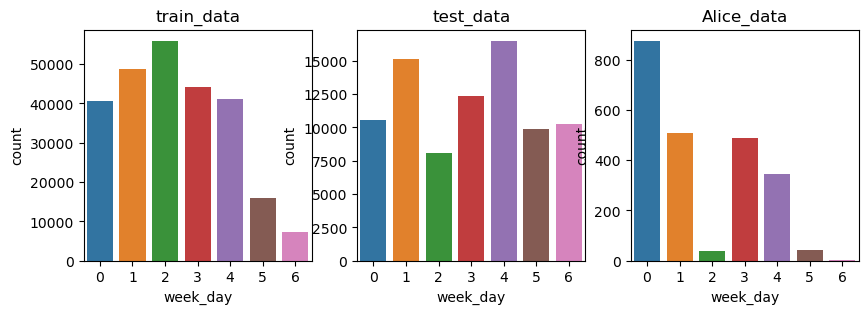

In [134]:
plt.figure(figsize=(10,3))

plt.subplot(1,3,1)
plt.title('train_data')
sns.countplot(x=train_data['week_day'])

plt.subplot(1,3,2)
plt.title('test_data')
sns.countplot(x=test_data['week_day'])

plt.subplot(1,3,3)
plt.title('Alice_data')
sns.countplot(x = train_data[train_data.target == 1]['week_day']);

In [144]:
def day_of_week_feature (X_sparced, df):
    X_weekday = hstack([X_sparced, df['time1'].apply(lambda x: x.weekday()).values.reshape(-1,1)])
    return X_weekday

In [147]:
X_train_time_weekday = day_of_week_feature(X_train_time, train_data)
X_test_time_weekday = day_of_week_feature(X_test_time, test_data)

In [149]:
cross_val_on_logit(X_train_time_weekday, y, logit_params)

[0.90201266 0.83931516 0.9393215  0.9605047  0.96283868] среднее значение на кросс-валидации =  0.9207985417837993


#### SUBMISSION 3 (LogisticRegression + Vectorized site sessions + Session start time + WeekDay):
CV_score = 0.907, Kaggle_public =  NOT PUBLISHED (worse result than without weekday Feature)

____

## Add Feature (Session Duration)

In [199]:
session_duration_train = (train_data[times].max(axis=1) - train_data[times].min(axis=1)).astype(int)
session_duration_test = (test_data[times].max(axis=1) - test_data[times].min(axis=1)).astype(int)

In [200]:
scaler = StandardScaler()
duration_train_scaled = scaler.fit_transform(session_duration_train.values.reshape(-1,1))
duration_test_scaled = scaler.transform(session_duration_test.values.reshape(-1,1))

In [202]:
X_train_time_dur = hstack([X_train_time, duration_train_scaled])
X_test_time_dur = hstack([X_test_time, duration_test_scaled])

In [203]:
cross_val_on_logit(X_train_time_dur, y, logit_params)

[0.9186962  0.89240214 0.9288449  0.94906304 0.95226753] среднее значение на кросс-валидации =  0.9282547607819203


In [207]:
y_time_dur_pred = logit_prediction(X_train_time_dur, X_test_time_dur, y, logit_params)

In [213]:
write_to_submission_file(y_time_dur_pred[:,-1], 'logit_with_time_dur.csv')

In [214]:
tmp = pd.read_csv('/Users/nikita/Desktop/git/private_repo/logit_with_time_dur.csv')